<a href="https://colab.research.google.com/github/allansuzuki/OCR_Tesseract/blob/main/OCR_Tesseract_with_OpenCV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#project from:
# https://pyimagesearch.com/2018/09/17/opencv-ocr-and-text-recognition-with-tesseract/

In [2]:
# install
!pip install opencv-python
!pip install opencv-contrib-python
!sudo apt install tesseract-ocr

!pip install pillow
!pip install pytesseract
!pip install imutils

# get the model pre trained
!git clone https://github.com/sanifalimomin/Text-Detection-Using-OpenCV.git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 8 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 0s (12.6 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debcon

In [ ]:
import cv2
import pytesseract
import imutils

# .
# ├── images
# │   ├── example_01.jpg
# │   ├── example_02.jpg
# │   ├── example_03.jpg
# │   ├── example_04.jpg
# │   └── example_05.jpg
# ├── frozen_east_text_detection.pb
# └── text_recognition.py

In [51]:
# text_recognition.py
from imutils.object_detection import non_max_suppression
import numpy as np
import pytesseract
import argparse
import cv2
from google.colab.patches import cv2_imshow

def ocr_image(image, model,config = '-l eng --oem 1 --psm 7', min_confidence=0.5, width=32, height=32, padding=0):

    def decode_predictions(scores, geometry):
        # grab the nrows and ncols from the scores volume, then
        # initialize our set of bounding box rectangles and
        # corresponding confidence scores
        (nrows, ncols) = scores.shape[2:4]
        rects = []
        confidences = []

        # loop nrows
        for y in range(nrows):
            # extract the scores, followed by the geometrical
            # data used to derive bounding box coords
            scoresData = scores[0, 0 , y]
            xData0 = geometry[0, 0, y]
            xData1 = geometry[0, 1, y]
            xData2 = geometry[0, 2, y]
            xData3 = geometry[0, 3, y]
            anglesData = geometry[0, 4, y]

            #loop ncols
            for x in range (ncols):
                # set probability threshold
                if scoresData[x] < min_confidence: continue

                # compute the offset factor as our resulting feature
                # maps will be 4x smaller than the input imade
                (offsetX, offsetY) = (x * 4.0, y * 4.0)

                # extract the rotation angle for the prediction and
                # then compute sin and cos
                angle = anglesData[x]
                cos = np.cos(angle)
                sin = np.sin(angle)

                # use the geometry volume to derive the width and
                # height of the bouding box
                h = xData0[x] + xData2[x]
                w = xData1[x] + xData3[x]

                # compute the start and ending (x,y) bounding box
                endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
                endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
                startX = int(endX - w)
                startY = int(endY - h)

                # add the bound box coord and proba score to a list
                rects.append((startX, startY, endX, endY))
                confidences.append(scoresData[x])

        return (rects, confidences)

    # definitions
    RED = (0,0,255)

    # load the input image and grab dimension
    image = cv2.imread(image)
    orig = image.copy()
    (origH, origW) = image.shape[:2]

    # set the new width and height and then the ratio in change
    # for both the width and height
    (newW, newH) = (width, height)
    rW = origW / float(newW)
    rH = origH / float(newH)

    # resize img and grab img dimensions
    image = cv2.resize(image, (newW, newH))
    (H, W) = image.shape[:2]

    # define the two output layer names for EAST detector model that
    # we are interested in: first is the output probabilities,
    # second can be used to derive the bounding box coords of text
    layerNames = [
        'feature_fusion/Conv_7/Sigmoid',
        'feature_fusion/concat_3'
    ]

    # load the pre-trained EAST text detector
    print("[INFO] loading EAST text detector...")
    net = cv2.dnn.readNet(model)

    # construct blob fom the image and then perform a fwd pass of
    # the model to obtain the two output layer sets
    blob = cv2.dnn.blobFromImage(image, 1.0, (H,W),
                                (123.68, 116.78, 103.94), swapRB=True, crop=False)
    net.setInput(blob)
    (scores, geometry) = net.forward(layerNames)

    # decode the predictions, then apply NMS to supress weak,
    # overlapping bounding boxes
    (rects, confidences) = decode_predictions(scores, geometry)
    boxes = non_max_suppression(np.array(rects), probs=confidences)


    # initialize list of results
    results = []

    # loop over the bounding boxes
    for (startX, startY, endX, endY) in boxes:
        # scale the bounding box coord based on the respective ratio
        startX = int(startX * rW)
        startY = int(startY * rH)
        endX = int(endX * rW)
        endY = int(endY * rH)

        # in order to obtain a better OCR of the text we can
        # potencially apply a bit of padding in the box -- in all
        # directions
        dX = int((endX - startX) * padding)
        dY = int((endY - startY) * padding)

        # apply padding
        startX = max(0, startX-dX)
        startY = max(0, startY-dY)
        endX = min(origW, endX + (dX*2))
        endY = min(origH, endY + (dY*2))

        # extract the actual padded ROI
        roi = orig[startY:endY, startX:endX]

        # in order to apply Tesseract v4 to OCR text we must apply
        # (1) a language, (2) an OEM flag of 1, indicating that we want
        # to use the LSTM neural net model, (3) an OEM value, in this case
        # 7, which implies in treat the ROI as a single line of text

        text = pytesseract.image_to_string(roi, config=config)

        #add the bounding box coords and OCR'd text to results list
        results.append(((startX, startY, endX, endY), text))

    #sort results from top to bottom
    results = sorted(results, key= lambda r: r[0][1])   #by y-coord

    # loop over the results
    for ((xi, yi, xf, yf), text) in results:
        # display text OCR'd by Tesseract
        print('OCR TEXT')
        print('========')
        print(f'{text}')

        # take out non-ASCII text
        text = "".join([c if ord(c)<128 else "" for c in text]).strip()
        output = orig.copy()
        # draw text and bounding box on image
        cv2.rectangle(output, (xi,yi),(xf,yf), RED, 2)
        cv2.putText(output, text, (xi,yi-20), cv2.FONT_HERSHEY_SIMPLEX, 1.2,RED, 3)

    # show the output image
    cv2_imshow(output)

[INFO] loading EAST text detector...
OCR TEXT
“4 MAKE TEXT
STAND OUT FROM

  



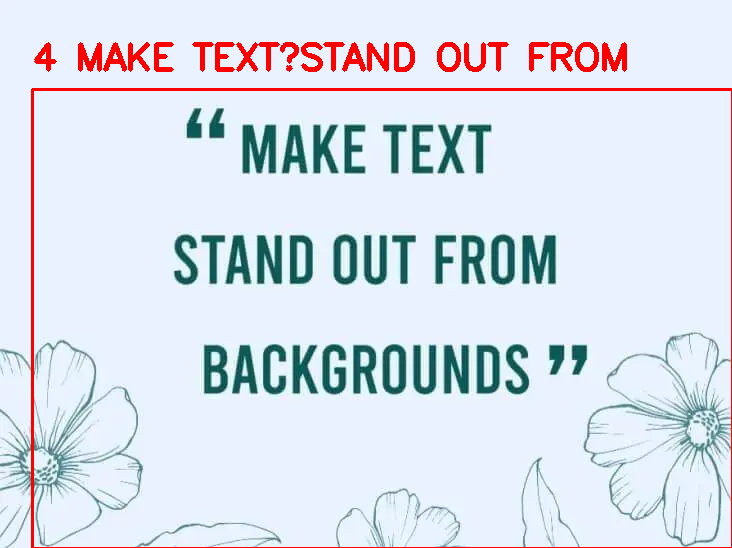

In [57]:
img_path = '/content/samples/sample001.png'
model_path = '/content/Text-Detection-Using-OpenCV/frozen_east_text_detection.pb'

ocr_image(img_path, model_path, config = '-l eng --oem 1 --psm 3', padding=.2)